In [83]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

In [49]:
with open("../data/training_data/inputs.json", "r") as file:
    X = np.array(json.load(file))
with open("../data/training_data/outputs.json", "r") as file:
    y = np.array(json.load(file), dtype=np.int8)

In [23]:
X.shape, y.shape

((20594, 12), (20594,))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [145]:
def elo_probability(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

In [146]:
X_train[:10][:,:2]

array([[1523.7391142 , 1522.29284466],
       [1521.43551702, 1544.49597133],
       [1483.82072927, 1538.32566098],
       [1481.76432551, 1502.45585048],
       [1478.07975161, 1519.08369168],
       [1506.2915705 , 1460.06962456],
       [1555.00965215, 1492.89997126],
       [1482.32845712, 1471.4425732 ],
       [1499.54935526, 1502.56823576],
       [1509.95012163, 1511.38814114]])

In [147]:
n_bins = 20

In [149]:
elo_probability(1000, 500)

0.9467597847979775

In [148]:
# ELO based classifier
elo_probability_preds = []
for row in X_train:
    elo_probability_preds.append(elo_probability(row[0], row[1]))
elo_prob_true, elo_prob_pred = calibration_curve(y_train, elo_probability_preds, n_bins=n_bins)
sum(elo_probability_preds), sum(y_train)

(7963.110056842791, 8238)

In [139]:
# Logistic regression
log_clf = LogisticRegression(random_state=42).fit(X_train, y_train)
log_preds = log_clf.predict(X_train)
log_probability_preds = log_clf.predict_proba(X_train)[:,1]
log_prob_true, log_prob_pred = calibration_curve(y_train, log_probability_preds, n_bins=n_bins)
sum(log_preds), sum(y_train)

(11964, 8238)

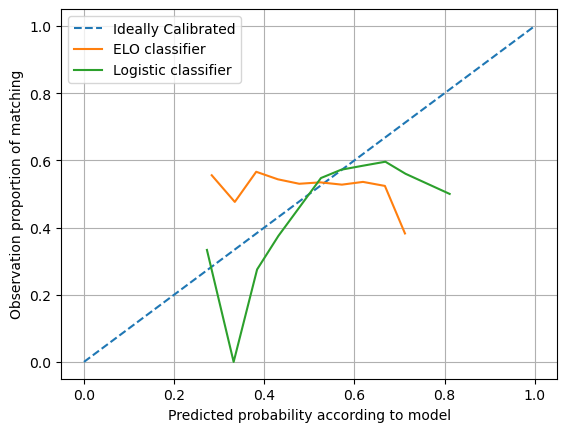

In [140]:
plt.plot([0, 1], [0, 1], linestyle = "--", label = "Ideally Calibrated")
plt.plot(elo_prob_pred, elo_prob_true, label="ELO classifier")
plt.plot(log_prob_pred, log_prob_true, label="Logistic classifier")
plt.xlabel("Predicted probability according to model")
plt.ylabel("Observation proportion of matching")
plt.legend()
plt.grid()
plt.show()